In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Check if GPU is availabl
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)


# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Ensure TensorFlow does not attempt to use multiple GPUs
if gpus:
    try:
        # Set memory growth to prevent the error
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)  # If memory growth is already set, continue

Num GPUs Available: 2
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU enabled for TensorFlow!
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Memory growth set for GPUs


In [3]:
train_path = "/kaggle/input/teeth-cellula/Teeth_Dataset/Training"
val_path = "/kaggle/input/teeth-cellula/Teeth_Dataset/Validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)



val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

print("Class indices:", train_generator.class_indices)
print("Class indices:", val_generator.class_indices)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
Class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,333,703 (27.98 MB)

 Trainable params: 296,199 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [5]:
batch_x, batch_y = next(train_generator)
print("Image batch shape:", batch_x.shape)  # Should be (batch_size, 224, 224, 3)
print("Label batch shape:", batch_y.shape)  # Should be (batch_size, 7)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 104s 779ms/step - accuracy: 0.1540 - loss: 2.2348 - val_accuracy: 0.3424 - val_loss: 1.7563
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.2602 - loss: 1.8570 - val_accuracy: 0.4377 - val_loss: 1.6012
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.3192 - loss: 1.7194 - val_accuracy: 0.4776 - val_loss: 1.4661
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 408ms/step - accuracy: 0.3575 - loss: 1.6334 - val_accuracy: 0.5272 - val_loss: 1.3712
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.3951 - loss: 1.5475 - val_accuracy: 0.5749 - val_loss: 1.2808
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.4431 - loss: 1.4520 - val_accuracy: 0.5924 - val_loss: 1.2170
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - accuracy: 0.4744 - loss: 1.4070 - val_accuracy: 0.6177 - val_loss: 1.1395
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.4790 - loss: 1.3495 - val_accuracy: 0.63

In [7]:
model.save('/kaggle/working/densenet121_teeth_model.keras')

In [8]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Again (Fine-Tuning)
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Shorter training for fine-tuning
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 89s 617ms/step - accuracy: 0.5827 - loss: 1.1519 - val_accuracy: 0.8230 - val_loss: 0.5641
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.6521 - loss: 0.9791 - val_accuracy: 0.8210 - val_loss: 0.5537
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.6704 - loss: 0.9025 - val_accuracy: 0.8239 - val_loss: 0.5475
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.6800 - loss: 0.8847 - val_accuracy: 0.8181 - val_loss: 0.5396
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - accuracy: 0.7001 - loss: 0.8365 - val_accuracy: 0.8249 - val_loss: 0.5242
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 400ms/step - accuracy: 0.6856 - loss: 0.8622 - val_accuracy: 0.8278 - val_loss: 0.5142
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.6959 - loss: 0.8590 - val_accuracy: 0.8298 - val_loss: 0.5047
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 400ms/step - accuracy: 0.7141 - loss: 0.7790 - val_accu

In [9]:
model.save("/kaggle/working/densenet121_finetuned_final.keras")

In [10]:
checkpoint = ModelCheckpoint(
    "/kaggle/working/densenet121_finetuned1.keras", 
    save_best_only=True, monitor="val_accuracy", mode="max"
)
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [11]:
for layer in base_model.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Again (Fine-Tuning)
history_fine1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Shorter training for fine-tuning
    callbacks=[checkpoint, early_stop] 
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 99s 670ms/step - accuracy: 0.7113 - loss: 0.8067 - val_accuracy: 0.8444 - val_loss: 0.4690
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - accuracy: 0.7029 - loss: 0.7958 - val_accuracy: 0.8405 - val_loss: 0.4622
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.7084 - loss: 0.8136 - val_accuracy: 0.8492 - val_loss: 0.4533
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 409ms/step - accuracy: 0.7269 - loss: 0.7473 - val_accuracy: 0.8541 - val_loss: 0.4404
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.7437 - loss: 0.7217 - val_accuracy: 0.8531 - val_loss: 0.4336
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 413ms/step - accuracy: 0.7384 - loss: 0.7145 - val_accuracy: 0.8589 - val_loss: 0.4155
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.7435 - loss: 0.7067 - val_accuracy: 0.8609 - val_loss: 0.4056
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 409ms/step - accuracy: 0.7408 - loss: 0.7205 - val_accu

In [12]:
checkpoint2 = ModelCheckpoint(
    "/kaggle/working/densenet121_finetuned2.keras", 
    save_best_only=True, monitor="val_accuracy", mode="max"
)
early_stop2 = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [13]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.000001),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Again (Fine-Tuning)
history_fine2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Shorter training for fine-tuning
    callbacks=[checkpoint, early_stop] 
)

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 113s 720ms/step - accuracy: 0.7273 - loss: 0.7768 - val_accuracy: 0.8862 - val_loss: 0.3621
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.7394 - loss: 0.7402 - val_accuracy: 0.8804 - val_loss: 0.3815
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - accuracy: 0.7419 - loss: 0.7397 - val_accuracy: 0.8794 - val_loss: 0.3930
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 453ms/step - accuracy: 0.7482 - loss: 0.7080 - val_accuracy: 0.8823 - val_loss: 0.4000


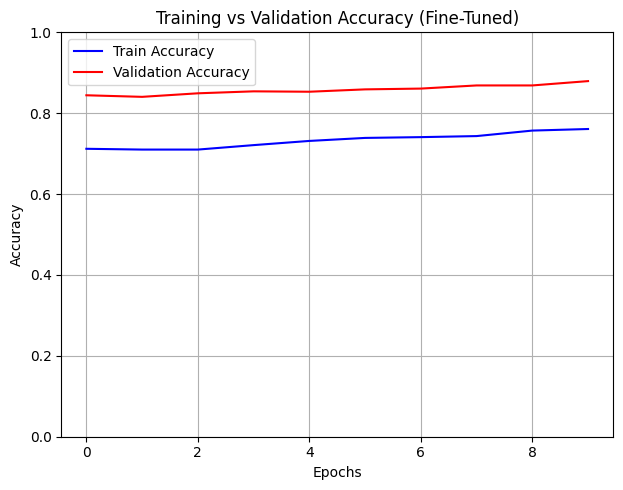

In [14]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine1.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_fine1.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Fine-Tuned)')
plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

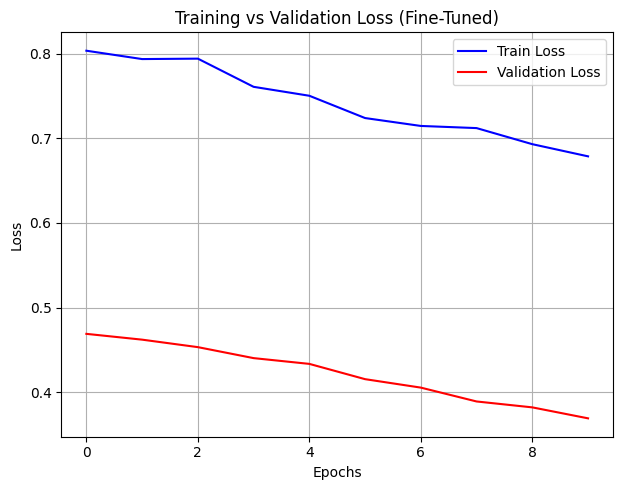

In [15]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history_fine1.history['loss'], label='Train Loss', color='blue')
plt.plot(history_fine1.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Fine-Tuned)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [18]:
loaded_model = tf.keras.models.load_model("/kaggle/working/densenet121_finetuned1.keras")

In [19]:
def predict_teeth(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    
    print(f"Predicted Class: {list(train_generator.class_indices.keys())[class_index]}")
    print(f"Predicted Label Index: {class_index}")


predict_teeth("/kaggle/input/teeth-cellula/Teeth_Dataset/Testing/Gum/g_1201_0_8478.jpg", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class: Gum
Predicted Label Index: 2
